# The goal
How to deal with tweets? Start with unsupervised unclassified data. What can you learn from unstructured Twitter data? Use unsupervised learning.

Ideally, we'd like to have a broad understanding of what the tweets were about. This is called topic modeling. 
Here we will use an algorithm called Latent Dirichlet Algorithm (LDA). Some intermediate steps are data cleaning and matching heterogeneous datasets. Ultimately this will lead to a more guided data understanding

In [4]:
%matplotlib inline

import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from collections import Counter
import operator
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import Pyro4

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import seaborn as sns

/Users/Peter/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# First load the data into a pandas dataframe

In [5]:
kagTweets = pd.read_csv('kaggleTweets.csv')

In [6]:
tweets = pd.read_csv('Tweets-CustomerSupport.csv', sep=';',index_col='id')
tweets = tweets.drop_duplicates('tweetId')
tweets.columns = ['account','from_handler','to_handler','message','time_stamp','tweet_id']

In [7]:
tweets = pd.read_csv('Tweets-CustomerSupport.csv', sep=';',index_col='id')

In [8]:
#Get rid of duplicate tweets
tweets = tweets.drop_duplicates('tweetId')

In [9]:
def getToFromTweets(userAccount,toTweet=True):
    """Function to print the number of tweets from a given account"""
    if toTweet==True:
        toFrom = 'toHandler'
    else:
        toFrom = 'fromHandler'
    tweetNum = str(np.sum(tweets[toFrom]==userAccount))
    #tweetNum = str(np.sum(tweets['toHandler']==userAccount))
    if toTweet==True:
        print 'Tweets to %s: %s' % (userAccount, tweetNum)
    else:
        print 'Tweets from %s: %s' % (userAccount, tweetNum)

In [10]:
for i in list(np.unique(tweets.account)):
    getToFromTweets(i,False)

Tweets from @1ShirtSupport: 3202
Tweets from @Airbnb: 3201
Tweets from @AmazonHelp: 3213
Tweets from @AskAmex: 3201
Tweets from @Avis: 3200
Tweets from @BCBSIL: 3230
Tweets from @GoDaddyHelp: 3238
Tweets from @Hootsuite_Help: 3240
Tweets from @InstapaperHelp: 3228
Tweets from @JetBlue: 3200
Tweets from @Kohls: 3207
Tweets from @MasterCard: 3205
Tweets from @MicrosoftHelps: 3211
Tweets from @TmobileHelp: 0
Tweets from @americanair: 0
Tweets from @fedexhelp: 0
Tweets from @nikestore: 3204
Tweets from @schuh: 3230
Tweets from @verizon: 3243


In [11]:
for i in list(np.unique(tweets.account)):
    getToFromTweets(i,True)

Tweets to @1ShirtSupport: 532
Tweets to @Airbnb: 23
Tweets to @AmazonHelp: 2991
Tweets to @AskAmex: 43
Tweets to @Avis: 360
Tweets to @BCBSIL: 78
Tweets to @GoDaddyHelp: 526
Tweets to @Hootsuite_Help: 180
Tweets to @InstapaperHelp: 37
Tweets to @JetBlue: 75
Tweets to @Kohls: 681
Tweets to @MasterCard: 38
Tweets to @MicrosoftHelps: 653
Tweets to @TmobileHelp: 0
Tweets to @americanair: 0
Tweets to @fedexhelp: 0
Tweets to @nikestore: 6295
Tweets to @schuh: 495
Tweets to @verizon: 71


In [12]:
companyList = list(np.unique(tweets.account))
companyList.append('@TMobileHelp')
companyList.append('@AmericanAir')
companyList.append('@FedExHelp')

#companyList
#list(np.unique(tweets.fromHandler))

In [13]:
usrIdx = tweets['fromHandler'].isin(companyList)
usrTweets = tweets[~usrIdx]
compTweets = tweets[usrIdx]
#tweets[tweets['fromHandler'].isin(list(np.unique(tweets.account)))]

In [14]:
#verTweets = tweets[tweets.fromHandler=='@verizon']

# Gensim code

In [15]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim import corpora, models
from gensim.similarities import MatrixSimilarity
from gensim.utils import SaveLoad
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import timeit
from re import sub
import pyLDAvis.gensim
from collections import Counter
from gensim.matutils import corpus2csc, sparse2full, corpus2dense
from wordcloud import WordCloud
from sklearn.utils import resample



In [16]:
#Functions for data cleaning

wnl = WordNetLemmatizer()

def removePunc(myWord):
    """Function to remove punctuation from string inputs"""
    if myWord is None:
        return myWord
    else:
        return sub('[.:;()/!&-*@$,?^\d+]','',myWord)
        
def removeAscii(myWord):
    """Function to remove ascii from string input"""
    if myWord is None:
        return myWord
    else:
        return str(sub(r'[^\x00-\x7F]+','', myWord.decode('utf-8').strip()))

def lemmatize(myWord):
    """Function to lemmatize words"""
    if myWord is None:
        return myWord
    else:
        return wnl.lemmatize(myWord)

def removeStopWords(myWord):
    """Function to remove stop words"""
    if myWord is None:
        return myWord
    if myWord not in str(stopwords.words('english')):
        return myWord

def removeLinkUser(myWord):
    """Function to remove web addresses and twitter handles"""
    if not myWord.startswith('@') and not myWord.startswith('http'):
        return myWord

def prepText(myWord):
    """Final text pre-processing function"""
    return removeStopWords(
        lemmatize(
            removeAscii(
                removePunc(
                    removeLinkUser(
                        myWord.lower()
                    )
                )
            )
        )
    )


In [17]:
# Function to clean/filter all tweets

def filterTweetList(tweetList):
    """Remove stop words, lemmatize, and clean all tweets"""
    return [[prepText(word) for word
                in tweet.split()
                    if prepText(word) is not None]
                for tweet in tweetList]
cleanedTweetList = filterTweetList(tweets['message'])

In [33]:
def makeDict(myTweetList):
    """Create dictionary from list of tokenized documents"""
    return corpora.Dictionary(myTweetList)

def makeCorpus(myTweetList,myDict):
    """Create corpus from list of tokenized documents"""
    return [myDict.doc2bow(tweet) for tweet in myTweetList]

def createLDA(myCorpus, myDictionary,myTopics=50,myPasses=10,myIterations=50,myAlpha=0.001):
    """LDA model call function"""
    return models.LdaMulticore(myCorpus, id2word=myDictionary, num_topics=myTopics, passes=myPasses,
    iterations=myIterations,alpha=myAlpha)

#lsi = models.LsiModel(myCorpus, id2word=myDict, num_topics=50)
# lsi has lower accuracy than lda

In [19]:
myDict = makeDict(cleanedTweetList)
myCorpus = makeCorpus(cleanedTweetList, myDict)
myLda = createLDA(myCorpus, myDict)

In [20]:
myLda = createLDA(myCorpus, myDict)

In [21]:
# turn on automatic rendering of visualizations
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(myLda, myCorpus, myDict)

/Users/Peter/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/Peter/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
12     6.809999        1       1 -0.269521 -0.150921
13     3.526701        1       2 -0.166533  0.006121
17     3.440368        1       3 -0.006537  0.139565
21     3.013744        1       4 -0.205936  0.047659
23     2.969772        1       5  0.002612 -0.082442
28     2.798860        1       6 -0.005884 -0.078566
34     2.622714        1       7 -0.115984  0.001393
1      2.620457        1       8 -0.131106 -0.081096
3      2.400400        1       9  0.018996  0.083336
8      2.335233        1      10 -0.167211  0.009378
30     2.293631        1      11 -0.047503  0.046955
25     2.260436        1      12  0.070705 -0.013124
41     2.156391        1      13  0.005706  0.023937
47     2.155244        1      14  0.131137 -0.080509
26     2.123483        1      15 -0.070539  0.077959
40     2.070894        1      16  0.102409 -0.076387
10     2.064000        1      17  0.065609 -0.098645
16     2.055294        1      18 -0.102037 -0.075497
15     2.004282        1      19  0.030526  0.180564
0      2.002744        1      20 -0.126783 -0.053933
2      1.911236        1      21 -0.023334 -0.085952
33     1.901765        1      22  0.105584  0.009080
4      1.844523        1      23 -0.018592  0.142507
24     1.839790        1      24  0.070699 -0.024326
37     1.826421        1      25 -0.144699  0.015915
11     1.773815        1      26 -0.053767  0.086629
14     1.749037        1      27  0.065473 -0.160485
9      1.729678        1      28  0.102309  0.110174
36     1.715842        1      29  0.137229  0.050004
44     1.713201        1      30  0.088335 -0.081925
29     1.708902        1      31  0.066531  0.096384
19     1.676499        1      32 -0.120048 -0.073753
18     1.655787        1      33 -0.067616  0.033644
31     1.570497        1      34 -0.096456  0.009655
45     1.541708        1      35  0.071034 -0.081463
42     1.525678        1      36  0.016715  0.061796
49     1.484724        1      37  0.052231  0.058443
5      1.472159        1      38  0.074217  0.029998
6      1.462817        1      39 -0.022754  0.066595
7      1.418143        1      40 -0.022624  0.114905
27     1.361415        1      41  0.042849  0.077010
46     1.337252        1      42  0.047526  0.029173
32     1.312945        1      43  0.044924 -0.017164
38     1.310246        1      44  0.086802 -0.023019
43     1.299392        1      45  0.132369 -0.087469
35     1.298436        1      46  0.105533 -0.071139
39     1.272534        1      47  0.070695 -0.152939
22     1.210153        1      48  0.084160 -0.026484
48     1.181929        1      49  0.055132  0.045801
20     1.168827        1      50  0.037418  0.022658, topic_info=      Category         Freq       Term  Total  loglift  logprob
8169   Default  5270.000000        let   5270  30.0000  30.0000
27790  Default  5192.000000       know   5192  29.0000  29.0000
8766   Default  8069.000000         dm   8069  28.0000  28.0000
21274  Default  3687.000000       time   3687  27.0000  27.0000
26527  Default  3872.000000      check   3872  26.0000  26.0000
5022   Default  3550.000000       like   3550  25.0000  25.0000
24917  Default  2911.000000      thank   2911  24.0000  24.0000
22807  Default  2776.000000      youre   2776  23.0000  23.0000
16830  Default  4519.000000       look   4519  22.0000  22.0000
7222   Default  3729.000000      happy   3729  21.0000  21.0000
26197  Default  3380.000000      phone   3380  20.0000  20.0000
7446   Default  3373.000000       take   3373  19.0000  19.0000
7861   Default  3955.000000     number   3955  18.0000  18.0000
24061  Default  2591.000000       need   2591  17.0000  17.0000
25481  Default  9654.000000     please   9654  16.0000  16.0000
22221  Default  2833.000000      great   2833  15.0000  15.0000
16694  Default  2529.000000      issue   2529  14.0000  14.0000
457    Default  2999.000000    address   2999  13

## Clean the data, build the dict and corpus, and call the LDA model

In [20]:
cleanedUsrTweetList = filterTweetList(usrTweets['message'])
usrDict   = makeDict(cleanedUsrTweetList)
usrCorpus = makeCorpus(cleanedUsrTweetList, usrDict)
usrLda = createLDA(usrCorpus, usrDict)

In [21]:
pyLDAvis.gensim.prepare(usrLda, usrCorpus, usrDict)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
11     3.914137        1       1  0.204661  0.212211
17     3.256527        1       2  0.243586  0.045495
39     3.145632        1       3  0.204549  0.176845
30     2.962967        1       4 -0.146077  0.065400
22     2.660743        1       5 -0.135658  0.009307
34     2.658733        1       6 -0.146638  0.023764
27     2.616269        1       7 -0.085376  0.027384
2      2.601631        1       8 -0.114864  0.113049
25     2.564190        1       9  0.084728 -0.136722
40     2.401589        1      10 -0.094861  0.044567
29     2.292417        1      11 -0.083750  0.004578
48     2.291783        1      12 -0.102837  0.004301
3      2.208620        1      13 -0.120832  0.014924
9      2.164923        1      14  0.209977  0.124752
8      2.119087        1      15 -0.065521 -0.025924
15     2.117629        1      16 -0.089810 -0.029088
47     2.109051        1      17 -0.076326  0.003711
21     2.106589        1      18 -0.028000 -0.056981
41     2.053324        1      19  0.080334 -0.111340
36     2.032033        1      20 -0.067970 -0.008741
37     2.023992        1      21  0.170010  0.015139
33     2.000618        1      22 -0.030522  0.009350
32     1.986648        1      23 -0.039467 -0.024759
0      1.937912        1      24  0.141134 -0.141714
1      1.923389        1      25 -0.112597  0.049933
19     1.913679        1      26 -0.104775  0.119279
46     1.913152        1      27 -0.047154  0.023790
16     1.903232        1      28 -0.019342 -0.070905
38     1.887249        1      29  0.008336 -0.109163
45     1.885087        1      30  0.122851 -0.086230
7      1.866447        1      31 -0.034708 -0.118590
14     1.813122        1      32 -0.055474 -0.007372
18     1.801073        1      33 -0.072405  0.008806
43     1.714525        1      34  0.002401  0.037883
13     1.710938        1      35  0.168406  0.085769
42     1.666220        1      36  0.157222 -0.084575
6      1.646159        1      37  0.133480 -0.089672
4      1.644252        1      38  0.003569 -0.082155
31     1.625172        1      39 -0.035353  0.033893
12     1.574551        1      40 -0.030115 -0.008150
20     1.562104        1      41  0.155278  0.074242
49     1.560132        1      42 -0.072295  0.021481
35     1.484105        1      43 -0.013787 -0.042550
23     1.471644        1      44 -0.034061  0.016879
10     1.328127        1      45 -0.032136 -0.042050
28     1.262504        1      46  0.116082 -0.116132
24     1.225702        1      47 -0.026792  0.011160
44     1.210358        1      48 -0.068421  0.059106
26     1.134733        1      49 -0.070579  0.025412
5      1.045302        1      50  0.051898 -0.069596, topic_info=      Category         Freq         Term  Total  loglift  logprob
4340   Default  1682.000000          air   1682  30.0000  30.0000
1267   Default   897.000000          one    897  29.0000  29.0000
11697  Default  1162.000000         nike   1162  28.0000  28.0000
4423   Default   897.000000       thanks    897  27.0000  27.0000
926    Default  1052.000000         time   1052  26.0000  26.0000
5935   Default  1140.000000       jordan   1140  25.0000  25.0000
10000  Default   802.000000         back    802  24.0000  24.0000
7029   Default   525.000000        thank    525  23.0000  23.0000
13180  Default   509.000000        style    509  22.0000  22.0000
2199   Default   528.000000         kobe    528  21.0000  21.0000
7473   Default   603.000000          new    603  20.0000  20.0000
178    Default   485.000000         want    485  19.0000  19.0000
1345   Default   447.000000         take    447  18.0000  18.0000
4971   Default   426.000000         size    426  17.0000  17.0000
6282   Default   476.000000         game    476  16.0000  16.0000
13361  Default   444.000000    customize    444  15.0000  15.0000
11484  Default   592.000000            -    592  14.0000  14.0000
12960  Defaul

In [22]:
cleanCompTweetList = filterTweetList(compTweets['message'])
compDict   = makeDict(cleanCompTweetList)
compCorpus = makeCorpus(cleanCompTweetList, compDict)


In [23]:
compLda = createLDA(compCorpus, compDict)

In [24]:
pyLDAvis.gensim.prepare(compLda, compCorpus, compDict)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
19     5.513453        1       1 -0.293830  0.073696
6      4.381219        1       2 -0.325216  0.059837
38     3.953165        1       3 -0.169917 -0.074629
21     3.854413        1       4 -0.130898  0.046040
0      3.224011        1       5 -0.038616 -0.023122
7      3.036082        1       6  0.005546  0.143951
36     2.699589        1       7  0.038863 -0.039600
27     2.641476        1       8 -0.014662  0.167873
5      2.548032        1       9  0.061042 -0.024598
48     2.547802        1      10 -0.158609  0.072612
14     2.524178        1      11 -0.168597 -0.115783
30     2.451240        1      12  0.068526  0.115503
37     2.331844        1      13 -0.202278 -0.033180
13     2.248215        1      14  0.003128  0.159546
2      2.206032        1      15 -0.128189 -0.043696
47     2.135500        1      16  0.038125 -0.068694
1      2.051902        1      17 -0.006320 -0.212049
4      1.959520        1      18 -0.000479 -0.003145
33     1.921515        1      19 -0.027018  0.061875
46     1.918810        1      20 -0.086258 -0.081428
3      1.916504        1      21  0.012798  0.019064
26     1.824557        1      22 -0.016049 -0.070408
29     1.805679        1      23 -0.014836 -0.193209
41     1.803736        1      24  0.047072 -0.171270
35     1.752529        1      25  0.015288  0.111775
43     1.699208        1      26  0.100152  0.044105
24     1.692129        1      27  0.078080  0.024546
32     1.664993        1      28 -0.001060 -0.023815
11     1.625136        1      29 -0.053635  0.029766
8      1.524955        1      30  0.062707 -0.036144
15     1.521586        1      31  0.043031 -0.108670
31     1.520764        1      32  0.094557  0.039356
22     1.518218        1      33  0.103364 -0.038678
44     1.501739        1      34  0.066806  0.080244
9      1.488000        1      35 -0.082144  0.033867
34     1.480116        1      36  0.106891  0.113802
40     1.439555        1      37  0.036654  0.040163
25     1.428924        1      38  0.033896 -0.012044
42     1.409075        1      39  0.006906 -0.045679
10     1.373093        1      40  0.108981 -0.041369
49     1.361921        1      41  0.019925 -0.000745
23     1.354492        1      42  0.084775 -0.044164
20     1.322497        1      43  0.050207  0.051228
18     1.313379        1      44  0.072056  0.101768
39     1.209077        1      45  0.083380 -0.086038
28     1.200989        1      46  0.111052 -0.051131
17     1.141498        1      47  0.086582 -0.044300
12     1.032508        1      48  0.104457  0.053663
45     0.987947        1      49  0.080552  0.003912
16     0.937198        1      50  0.093214  0.039396, topic_info=      Category         Freq       Term  Total  loglift  logprob
10019  Default  6221.000000      sorry   6221  30.0000  30.0000
5928   Default  5005.000000     thanks   5005  29.0000  29.0000
3855   Default  4961.000000        let   4961  28.0000  28.0000
19695  Default  4756.000000       know   4756  27.0000  27.0000
16135  Default  3648.000000      check   3648  26.0000  26.0000
5647   Default  7782.000000         dm   7782  25.0000  25.0000
10917  Default  2651.000000      youre   2651  24.0000  24.0000
16101  Default  3495.000000       hear   3495  23.0000  23.0000
3865   Default  2588.000000      great   2588  22.0000  22.0000
1778   Default  2926.000000       take   2926  21.0000  21.0000
7902   Default  2209.000000      issue   2209  20.0000  20.0000
8305   Default  4314.000000       look   4314  19.0000  19.0000
17835  Default  3810.000000     number   3810  18.0000  18.0000
13211  Default  9170.000000     please   9170  17.0000  17.0000
4476   Default  3018.000000      email   3018  16.0000  16.0000
15152  Default  2837.000000      phone   2837  15.0000  15.0000
12141  Default  1990.000000     assist   1990  14.0000  14.0000
1339   Default  2934.000000    address   2934  13

In [22]:
kagTweets = pd.read_csv('kaggleTweets.csv')

In [23]:
cleanKagTweetList = filterTweetList(kagTweets['text'])



In [34]:
# Uncomment if these haven't been saved yet

kagDict   = makeDict(cleanKagTweetList)
kagCorpus = makeCorpus(cleanKagTweetList, kagDict)
kagLda = createLDA(kagCorpus, kagDict)

#SaveLoad.save(kagLda,'kaggleLDAmodel0201')
#corpora.MmCorpus.serialize('kaggleCorpus0201.mm', kagCorpus)
#kagDict.save('kaggleDictionary0201.dict')

In [305]:
# Load kaggle data
kagLda = SaveLoad.load('kaggleLDAmodel')
kagDict = corpora.Dictionary.load('kaggleDictionary.dict')
kagCorpus = corpora.MmCorpus('kaggleCorpus.mm')

In [306]:
#len(cleanKagTweetList[0])
#Counter([len(tweet) for tweet in cleanKagTweetList])

In [35]:
ldaViz = pyLDAvis.gensim.prepare(kagLda, kagCorpus, kagDict)

In [36]:
ldaViz

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
41     4.575341        1       1 -0.050721  0.226289
14     4.327949        1       2  0.110603  0.007379
31     4.078576        1       3 -0.203858  0.107104
33     3.162237        1       4 -0.050742  0.217985
45     2.678018        1       5 -0.108592 -0.137340
29     2.665579        1       6 -0.008070 -0.075962
48     2.494252        1       7  0.015383  0.013189
28     2.488779        1       8  0.036945 -0.087623
5      2.281343        1       9 -0.151671  0.009022
49     2.278764        1      10  0.071871 -0.026569
10     2.149618        1      11 -0.151928 -0.002171
34     2.136930        1      12 -0.023110  0.011040
27     2.103478        1      13  0.156863  0.116709
36     2.071990        1      14  0.092845  0.134183
47     2.019467        1      15  0.075911 -0.005422
30     1.911866        1      16 -0.035005  0.068835
6      1.910816        1      17 -0.044348  0.013283
21     1.910348        1      18 -0.012124  0.039046
9      1.901772        1      19 -0.152762 -0.032623
11     1.896558        1      20  0.007706 -0.025288
12     1.873479        1      21 -0.072999 -0.035315
8      1.850140        1      22  0.050640  0.053610
17     1.848083        1      23 -0.018029  0.024005
26     1.842589        1      24  0.086585  0.015383
40     1.800724        1      25  0.002177 -0.021630
20     1.783807        1      26 -0.013894 -0.076254
13     1.781481        1      27  0.023844 -0.040982
44     1.754887        1      28  0.029790  0.048802
43     1.744439        1      29 -0.061297 -0.018747
3      1.736639        1      30 -0.091144 -0.030259
15     1.733435        1      31  0.077554 -0.033981
38     1.730513        1      32 -0.076869 -0.074077
37     1.716067        1      33 -0.016755  0.048704
4      1.712296        1      34  0.038104 -0.026309
32     1.694653        1      35 -0.107061  0.003479
1      1.678388        1      36  0.087147 -0.027567
42     1.646889        1      37  0.053339  0.060279
0      1.641013        1      38  0.137233 -0.023933
23     1.611053        1      39  0.023481  0.044159
19     1.577418        1      40 -0.004811 -0.081383
22     1.536702        1      41  0.044141 -0.039017
18     1.503515        1      42  0.029465 -0.044848
25     1.490967        1      43  0.017364 -0.022255
2      1.487678        1      44  0.020464  0.056805
39     1.478497        1      45  0.000022 -0.148306
24     1.456783        1      46  0.038195 -0.005715
46     1.430210        1      47  0.039101 -0.054670
35     1.337640        1      48 -0.018591 -0.013183
7      1.256501        1      49  0.029599 -0.082218
16     1.219833        1      50  0.078011 -0.025647, topic_info=      Category         Freq          Term  Total  loglift  logprob
7318   Default   601.000000         thank    601  30.0000  30.0000
7674   Default  1048.000000     cancelled   1048  29.0000  29.0000
3775   Default  1066.000000        thanks   1066  28.0000  28.0000
139    Default   637.000000          hold    637  27.0000  27.0000
11646  Default  4494.000000        flight   4494  26.0000  26.0000
1277   Default   502.000000     flightled    502  25.0000  25.0000
7822   Default   538.000000       airline    538  24.0000  24.0000
322    Default   976.000000       service    976  23.0000  23.0000
2550   Default   917.000000      customer    917  22.0000  22.0000
8870   Default   253.000000            dm    253  21.0000  21.0000
8139   Default   423.000000          late    423  20.0000  20.0000
3163   Default   308.000000       problem    308  19.0000  19.0000
11970  Default   362.000000       waiting    362  18.0000  18.0000
10450  Default   216.000000       jetblue    216  17.0000  17.0000
6892   Default   238.000000           yes    238  16.0000  16.0000
8058   Default  1143.000000          hour   1143  15.0000  15.0000
4264   Default   305.000000      tomorrow    305  14.0000  14.

In [84]:
#kagIndex = MatrixSimilarity(kagLda[kagCorpus]) # transform corpus to LSI space and index it
#kagIndex.index.shape

# Using `top_topics` maps lda topics to the visualization

In [309]:
def translateLdaIdx(myLdaModel, myLdaViz):
    """Translate lda model topics to match the topics in pyLDAvis visualization"""
    ldaVizIdx = myLdaViz[0].index
    return list(ldaVizIdx)

In [310]:
newIdx = translateLdaIdx(kagLda,ldaViz)

In [311]:
def createDenseMat(myLdaModel,myCorpus,newIdx):
    """Transform corpus to dataframe with topics matching lda visualization"""
    numTopics = myLdaModel.num_topics
    myDense = corpus2dense(myLdaModel[myCorpus],numTopics)
    myDf = pd.DataFrame(myDense)
    mySortedDf = myDf.transpose()
    mySortedDf = myDf.transpose()[newIdx]
    mySortedDf.columns = ['topic' + str(i + 1) for i in range(numTopics)]
    return mySortedDf

In [312]:
kagDf = createDenseMat(kagLda,kagCorpus,newIdx)

In [313]:
### Working
def sortByTopicToIdx(cleanedTweetList,mySortedDf,myTopic,myTopicThresh=0.1):
    """Returns an index of tweets surpassing a topic value threshold"""
    myCleanArray = np.array(cleanedTweetList)
    srtIdx = list(mySortedDf[mySortedDf[myTopic]>myTopicThresh].index)
    return srtIdx

In [314]:
# Next up sort the tweets
def sortTweetsByIdx(cleanedTweetList,srtIdx):
    """Returns sorted tweets as a list based on a defined sort index"""
    myCleanArray = np.array(cleanedTweetList)
    srtTweets = list(myCleanArray[srtIdx])
    return srtTweets

In [315]:
# Get sorted tweet list
sortedIdx = sortByTopicToIdx(cleanKagTweetList,kagDf,'topic2',myTopicThresh=0.1)
# get sorted tweet list
sortedTpx2 = sortTweetsByIdx(cleanKagTweetList,sortedIdx)

In [316]:
#sortedTpx1

In [317]:
# Works
def makeWordCloud(cleanedTweetList,mySortedDf,myTopic,myTopicThresh=0.1):
    """Create word cloud of tweets passing a given threshold for a given topic"""
    sortedIdx = sortByTopicToIdx(cleanedTweetList,mySortedDf,myTopic,myTopicThresh=0.1)
    mySortedTweets = sortTweetsByIdx(cleanedTweetList,sortedIdx)
    filteredWords = ' '.join([' '.join(string) for string in mySortedTweets])
    myTopicCloud = WordCloud(max_font_size=100,scale=8).generate(filteredWords)
    fig = plt.figure(figsize=(10,10), dpi=1600)
    plt.imshow(myTopicCloud)
    plt.axis("off")
    plt.show()

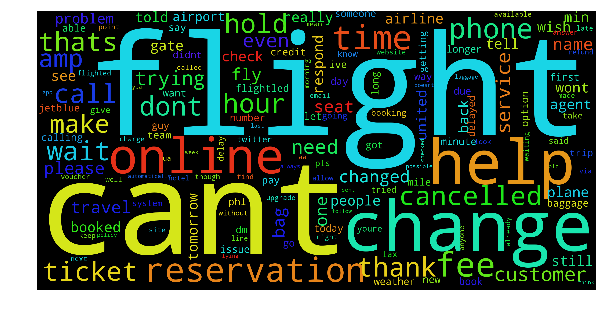

In [318]:
makeWordCloud(cleanKagTweetList,kagDf,'topic5',myTopicThresh=0.1)

In [319]:
"""# Working
def makeWordCloud(mySortedTweets):
    """Create word cloud of tweets passing a given threshold for a given topic"""
    filteredWords = ' '.join([' '.join(string) for string in mySortedTweets])
    #topicCloud = WordCloud(max_font_size=100,scale=8).generate(topicCloudWords)
    myTopicCloud = WordCloud(max_font_size=100,scale=8).generate(filteredWords)
    fig = plt.figure(figsize=(10,10), dpi=1600)
    plt.imshow(myTopicCloud)
    plt.axis("off")
    plt.show()
"""

SyntaxError: invalid syntax (<ipython-input-319-3272f240e9df>, line 3)

In [324]:
#makeWordCloud(sortedTpx2)

In [325]:
#sortedTpx2

In [326]:
#list(np.unique(kagTweets.airline))`

In [327]:
#kagTweets

In [328]:
def genSortedResample(myTweetDf,myIdx,myVar='airline'):
    """"""
    airlinePop = np.array(myTweetDf.loc[myIdx][myVar])
    len(airlinePop)
    #Counter(resample(airlinePop))
    airlineNames = list(np.unique(myTweetDf[myVar]))
    testDf=pd.DataFrame(columns=airlineNames)
    for i in range(1000):
        tempSample = pd.Series(dict(Counter(resample(airlinePop))))
        testDf = testDf.append(tempSample,ignore_index=True)
    totalAirTweets = dict(Counter(myTweetDf[myVar]))
    for i in totalAirTweets.keys():
        normVal = testDf[i]/float(totalAirTweets[i])
        testDf[i + '-norm'] = pd.Series(normVal,index=testDf.index)
    return testDf

In [329]:
airlineDistResample = genSortedResample(kagTweets,sortedIdx)

In [330]:
"""airlinePop = np.array(kagTweets.loc[sortedIdx]['airline'])
len(airlinePop)
#Counter(resample(airlinePop))
airlineNames = list(np.unique(kagTweets.airline))
testDf=pd.DataFrame(columns=airlineNames)
for i in range(1000):
    tempSample = pd.Series(dict(Counter(resample(airlinePop))))
    testDf = testDf.append(tempSample,ignore_index=True)
#testDf.head()
"""

"airlinePop = np.array(kagTweets.loc[sortedIdx]['airline'])\nlen(airlinePop)\n#Counter(resample(airlinePop))\nairlineNames = list(np.unique(kagTweets.airline))\ntestDf=pd.DataFrame(columns=airlineNames)\nfor i in range(1000):\n    tempSample = pd.Series(dict(Counter(resample(airlinePop))))\n    testDf = testDf.append(tempSample,ignore_index=True)\n#testDf.head()\n"

In [331]:
"""# Then normalize all data points to the original representation in the tweet dataset
totalAirTweets = dict(Counter(kagTweets['airline']))
for i in totalAirTweets.keys():
    normVal = testDf[i]/float(totalAirTweets[i])
    testDf[i + '-norm'] = pd.Series(normVal,index=testDf.index)
"""

"# Then normalize all data points to the original representation in the tweet dataset\ntotalAirTweets = dict(Counter(kagTweets['airline']))\nfor i in totalAirTweets.keys():\n    normVal = testDf[i]/float(totalAirTweets[i])\n    testDf[i + '-norm'] = pd.Series(normVal,index=testDf.index)\n"

In [332]:
#testDf.head()

In [333]:
#United vs American

In [334]:
# Then get the 95% CI for each airline
# Now I need to calc for each airline
testSort = np.sort(testDf['American-norm'])
low95 = testSort[24]
hi95 = testSort[975]
meanVal = np.mean(testSort)
print meanVal, low95, hi95


0.0923218557448 0.0815512866981 0.102935846321


In [335]:
def getResampleStats(resampleDf,airlineNames):
    statDf = pd.DataFrame(columns=['mean','low95','hi95'])
    for airline in airlineNames:
        tempName = airline + '-norm'
        tempSort = np.sort(resampleDf[tempName])
        meanVal = np.mean(tempSort)
        low95 = meanVal - tempSort[24] 
        hi95 = tempSort[975] - meanVal
        statDf = statDf.append({'mean': meanVal,'low95':low95,'hi95':hi95},ignore_index=True)

    statDf.index = airlineNames
    statDf = statDf.sort_values('mean')
    statDf = statDf/statDf.iloc[0]['mean']
    return statDf

In [336]:
def calcAirlineStats(cleanedTweetList,mySortedDf,myTopic,myTweetDf,myTopicThresh=0.1):
    """Create word cloud of tweets passing a given threshold for a given topic"""
    sortedIdx = sortByTopicToIdx(cleanedTweetList,mySortedDf,myTopic,myTopicThresh=0.1)
    mySortedTweets = sortTweetsByIdx(cleanedTweetList,sortedIdx)
    myResample = genSortedResample(myTweetDf,sortedIdx)
    myStats = getResampleStats(myResample,list(set(kagTweets['airline'])))
    return myStats
    #Why do I need the tweet DF? Just for index?

In [337]:
#kagDf
#kagTweets.head()

In [375]:
statDf = calcAirlineStats(cleanKagTweetList,kagDf,'topic2',kagTweets)

In [339]:
#statDf = getResampleStats(airlineDistResample,list(set(kagTweets['airline'])))

In [340]:
"""statDf = pd.DataFrame(columns=['mean','low95','hi95'])
for airline in airlineNames:
    tempName = airline + '-norm'
    tempSort = np.sort(testDf[tempName])
    meanVal = np.mean(tempSort)
    low95 = meanVal - tempSort[24] 
    hi95 = tempSort[975] - meanVal
    statDf = statDf.append({'mean': meanVal,'low95':low95,'hi95':hi95},ignore_index=True)

statDf.index = airlineNames
statDf = statDf.sort_values('mean')
statDf = statDf/statDf.iloc[0]['mean']
"""

"statDf = pd.DataFrame(columns=['mean','low95','hi95'])\nfor airline in airlineNames:\n    tempName = airline + '-norm'\n    tempSort = np.sort(testDf[tempName])\n    meanVal = np.mean(tempSort)\n    low95 = meanVal - tempSort[24] \n    hi95 = tempSort[975] - meanVal\n    statDf = statDf.append({'mean': meanVal,'low95':low95,'hi95':hi95},ignore_index=True)\n\nstatDf.index = airlineNames\nstatDf = statDf.sort_values('mean')\nstatDf = statDf/statDf.iloc[0]['mean']\n"

In [405]:
c = sns.color_palette('Set3',10)
#sns.palplot(c)

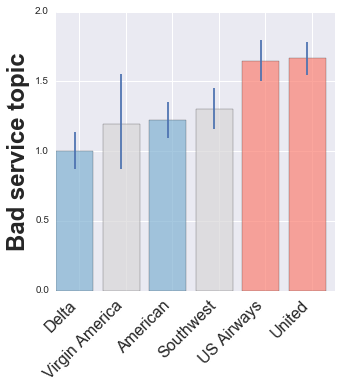

In [406]:
fig = plt.figure(figsize=(5,5), dpi=1600)
ax = plt.subplot(111)

barPlot = plt.bar(range(6),statDf.loc[:,'mean'],yerr=[list(statDf.loc[:,'low95']),list(statDf.loc[:,'hi95'])], \
                  alpha=0.7,color=[c[4],c[8],c[4],c[8],c[3],c[3]])
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in barPlot]
plt.xticks([i+0.5 for i in range(6)],list(statDf.index),rotation=45,ha='right',fontsize=16)
ax.set_ylabel('Bad service topic',fontsize=24,fontweight='bold')
plt.ylim([0,2])

plt.show()

In [372]:
jdAirline = {'Delta': 706, 'American': 700,'United': 665,'US Airways': 668,}
jdAirline.values()

[700, 665, 668, 706]

In [374]:
jdDf = pd.DataFrame(columns=['airline','value'])
for airline in jdAirline.keys():
    jdDf = jdDf.append(pd.Series({'airline':airline,'value': jdAirline[airline]}),ignore_index=True)
    #print pd.Series({'airline': jdAirline[airline],'value':airline})
    #print jdAirline[airline]

jdDf = jdDf.iloc[[3,0,1,2]]   
#jdDf.loc[:,'relativeValue'] = jdDf['value']/min(jdDf['value'])
#jdDf.loc[:,'relativeValue'] = jdDf['value']-min(jdDf['value'])
#jdDf.loc[:,'norm'] = jdDf.relativeValue/max(jdDf.relativeValue)
#jdDf.loc[:,'relativeValue'] = (jdDf['value']-691)/691*100
jdDf.loc[:,'relativeValue'] = (jdDf['value']-691)
#jdDf


(-30, 20)

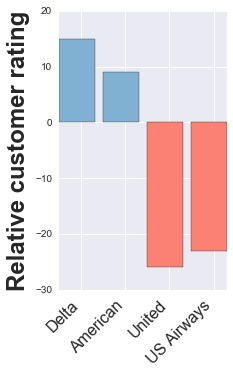

In [389]:
fig = plt.figure(figsize=(3,5), dpi=1600)
ax = plt.subplot(111)

#sns.barplot(x='airline',y='value',data=jdDf)

xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in barPlot]
plt.xticks([i+0.5 for i in range(6)],list(jdDf.airline),rotation=45,ha='right',fontsize=16)
ax.set_ylabel('Relative customer rating',fontsize=24,fontweight='bold')

ax = plt.bar(range(len(jdDf)),jdDf['relativeValue'],color=[c[4],c[4],c[3],c[3]])
plt.ylim([-30,20])
#plt.ylim([500,750])

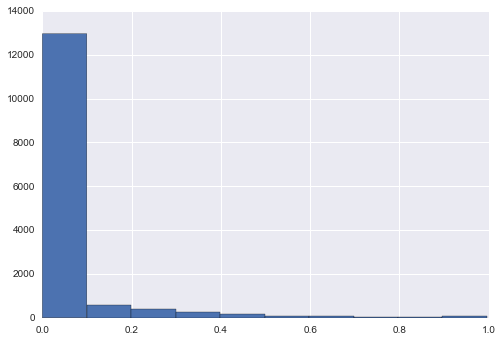

In [395]:
plt.hist(kagDf.topic2)
plt.show()

In [ ]:
testSort = np.sort(testDf['United-norm'])
low95 = testSort[24]
hi95 = testSort[975]
meanVal = np.mean(testSort)
print meanVal, low95, hi95

In [ ]:
len(set(resample(range(0,1000))))

In [ ]:
junk = np.array(range(1000))
len(junk[junk>24])
len(junk[junk<975])

In [ ]:
Counter(kagTweets.loc[sortByTopicTweet(kagCleanArray,kagDf,'topic27')]['airline'])

### Need to normailze to the proportional airline counts
### Have to sort list by list

In [ ]:
[airCounts[i]/float(testList[i]) for i in range(len(testList))]

In [ ]:
def plotTopicAirDist(origTweets,myTopic,mySortedDf):
    myCleanArray = np.array(cleanedTweetList)
    srtIdx = list(mySortedDf[mySortedDf[myTopic]>myTopicThresh].index)
    airCounts = Counter(origTweets.loc[sortByTopicTweet(kagCleanArray,kagDf,'topic27')]['airline'])

In [ ]:
airCounts = Counter(kagTweets.loc[sortByTopicTweet(kagCleanArray,kagDf,'topic27')]['airline'])
sortedAirCounts = sorted(airCounts.items(), key=lambda x: x[1],reverse=True)[0:5]

airNames = [airline[0] for airline in sortedAirCounts]
airCounts = [airline[1] for airline in sortedAirCounts]

indexes = np.arange(len(airNames))
width = 0.9
plt.bar(indexes, airCounts, width)
plt.xticks(indexes + width * 0.5, airNames)
plt.ylabel('Frequency',fontsize=16)

# Plot histogram using matplotlib bar().
#indexes = np.arange(len(author_names))
#width = 0.7
#plt.bar(indexes, author_counts, width)
#plt.xticks(indexes + width * 0.5, author_names)
plt.show()
#

In [ ]:
airCounts = Counter(kagTweets.loc[sortByTopicTweet(kagCleanArray,kagDf,'topic27')]['airline'])
sortedAirCounts = sorted(airCounts.items(), key=lambda x: x[1],reverse=True)[0:5]

airNames = [airline[0] for airline in sortedAirCounts]
airCounts = [airline[1] for airline in sortedAirCounts]

indexes = np.arange(len(airNames))
width = 0.9
plt.bar(indexes, airCounts, width)
plt.xticks(indexes + width * 0.5, airNames)
plt.ylabel('Frequency',fontsize=16)

# Plot histogram using matplotlib bar().
#indexes = np.arange(len(author_names))
#width = 0.7
#plt.bar(indexes, author_counts, width)
#plt.xticks(indexes + width * 0.5, author_names)
plt.show()
#

In [ ]:
totalAirCounts = Counter(kagTweets['airline'])
#totalAirCounts[['American','United'])]
sortedTotalAirCounts = sorted(totalAirCounts.items(), key=lambda x: x[1],reverse=True)[0:5]
testDict = dict(sortedTotalAirCounts)
testList = [testDict[airline] for airline in airNames]
normAirCounts = [airCounts[i]/float(testList[i])*100 for i in range(len(testList))]

airNames = [airline[0] for airline in sortedAirCounts]
#airCounts = [airline[1] for airline in sortedAirCounts]

indexes = np.arange(len(airNames))
width = 0.9
plt.bar(indexes, normAirCounts, width)
plt.xticks(indexes + width * 0.5, airNames)
plt.ylabel('Frequency',fontsize=16)



#[airline[0] for airline in sortedTotalAirCounts]
#[airline[1] for airline in sortedTotalAirCounts]

#airNames = [airline[0] for airline in sortedAirCounts]
#print sortedTotalAirCounts
#print sortedTotalAirCounts.keys()
#print sortedTotalAirCounts.values()

## Bootstrap resampling to get errors on the airline proportions

In [ ]:
### Working
def sortByTopic(cleanedTweetList,mySortedDf,myTopic,myTopicThresh=0.1):
    myCleanArray = np.array(cleanedTweetList)
    srtIdx = list(mySortedDf[mySortedDf[myTopic]>myTopicThresh].index)
    srtTweets = list(myCleanArray[srtIdx])
    return srtTweets

In [ ]:
airCounts = Counter(kagTweets.loc[sortByTopicTweet(kagCleanArray,kagDf,'topic27')]['airline'])
sortedAirCounts = sorted(airCounts.items(), key=lambda x: x[1],reverse=True)[0:5]

airNames = [airline[0] for airline in sortedAirCounts]
airCounts = [airline[1] for airline in sortedAirCounts]

indexes = np.arange(len(airNames))
width = 0.9
plt.bar(indexes, airCounts, width)
plt.xticks(indexes + width * 0.5, airNames)
plt.ylabel('Frequency',fontsize=16)

# Plot histogram using matplotlib bar().
#indexes = np.arange(len(author_names))
#width = 0.7
#plt.bar(indexes, author_counts, width)
#plt.xticks(indexes + width * 0.5, author_names)
plt.show()
#

In [ ]:
topHandlerCounts = Counter(topHandlers)
sortedHandlers = sorted(topHandlerCounts.items(), key=lambda x: x[1],reverse=True)[0:5]

handlerNames = [handler[0] for handler in sortedHandlers]
handlerCounts = [handler[1] for handler in sortedHandlers]

indexes = np.arange(len(handlerNames))
width = 0.9
plt.bar(indexes, handlerCounts, width)
plt.xticks(indexes + width * 0.5, handlerNames)
plt.ylabel('Frequency',fontsize=16)

# Plot histogram using matplotlib bar().
#indexes = np.arange(len(author_names))
#width = 0.7
#plt.bar(indexes, author_counts, width)
#plt.xticks(indexes + width * 0.5, author_names)
plt.show()
#

In [ ]:
topic24words = sortByTopic(cleanKagTweetList,kagDf,myTopic='topic24')

In [ ]:
#topic3words

In [ ]:
#def makeWordCloud(mySortedTweets):
#    filteredWords = ' '.join([' '.join(string) for string in mySortedTweets])
#    topicCloud = WordCloud(max_font_size=100,scale=8).generate(topicCloudWords)
#    return WordCloud(max_font_size=100,scale=8).generate(topicCloudWords)
    

In [ ]:
def makeWordCloud(mySortedTweets):
    filteredWords = ' '.join([' '.join(string) for string in mySortedTweets])
    #topicCloud = WordCloud(max_font_size=100,scale=8).generate(topicCloudWords)
    myTopicCloud = WordCloud(max_font_size=100,scale=8).generate(filteredWords)
    fig = plt.figure(figsize=(10,10), dpi=1600)
    plt.imshow(myTopicCloud)
    plt.axis("off")
    plt.show()

In [ ]:
makeWordCloud(topic24words)

In [ ]:
fig = plt.figure(figsize=(10,10), dpi=1600)
myTopicCloud=makeWordCloud(topic1words)
plt.imshow(myTopicCloud)
plt.axis("off")
plt.show()

In [ ]:
makeWordCloud(topic1words)
#makeWordCloud(cleanKagTweetList)

In [ ]:
#len(cleanKagTweetList)

In [ ]:
#sortByTopic(cleanKagTweetList,kagSortedDf2)

In [16]:
kagSortedDf2 = createDenseMat(kagLda,kagCorpus,translateIdx)

NameError: name 'createDenseMat' is not defined

In [17]:
kagCleanArray = np.array(cleanKagTweetList)
#kagCleanArray
srtIdx = list(kagSortedDf[kagSortedDf.col1>0.1].index)
srtTweets = list(kagCleanArray[srtIdx])
topicCloudWords = ' '.join([' '.join(string) for string in srtTweets])

NameError: name 'cleanKagTweetList' is not defined

In [ ]:
kagDense = corpus2dense(kagLda[kagCorpus],50)
kagDf = pd.DataFrame(kagDense)
kagSortedDf = kagDf.transpose()
kagSortedDf = kagDf.transpose()[translateIdx]
kagSortedDf.columns = ['col' + str(i + 1) for i in range(50)]
kagSortedDf.sort_values('col1',ascending=False).head()

In [154]:
#translateLdaIdx(kagLda)

In [151]:
#translateIdx

# is this right?

In [594]:
#idxDf = pd.DataFrame(columns=['first','second','third'])
#kagShowTopics

In [592]:
idxShufDf = pd.DataFrame(columns=['first','second','third'])
kagShowTopics = kagLda.show_topics(50)
for i in range(len(kagLda.show_topics(50))):
    idxShufDf.loc[i,'first']=kagShowTopics[i][1].split()[0].split('*')[1]
    idxShufDf.loc[i,'second']=kagShowTopics[i][1].split()[2].split('*')[1]
    idxShufDf.loc[i,'third']=kagShowTopics[i][1].split()[4].split('*')[1]
idxShufDf.head()

,first,second,third
0,person,service,experience
1,link,thx,agent
2,ever,member,ive
3,hour,flight,change
4,book,travel,guy


In [595]:
kagTopTopics = kagLda.top_topics(kagCorpus)
idxTopDf = pd.DataFrame(columns=['first','second','third'])
for i in range(len(kagTopTopics)):
    idxTopDf.loc[i,'first']=kagTopTopics[i][0][0][1] 
    idxTopDf.loc[i,'second']=kagTopTopics[i][0][1][1] 
    idxTopDf.loc[i,'third']=kagTopTopics[i][0][2][1] 

idxTopDf.head()

,first,second,third
0,hold,flight,help
1,flight,cancelled,flightled
2,flight,get,home
3,delayed,flight,time
4,flight,still,waiting


In [597]:
#idxTopDf

In [606]:
translateIdx

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

In [608]:
kagTopTopics[0]

([(0.069081547140009067, u'hold'),
  (0.051946239556114951, u'flight'),
  (0.048468121452699547, u'help'),
  (0.043372461265078183, u'call'),
  (0.037195251998753481, u'need'),
  (0.036742654078024288, u'hour'),
  (0.033349534254853958, u'tomorrow'),
  (0.032186123316162663, u'get'),
  (0.030014570866952694, u'reservation'),
  (0.028469339361524008, u'trying'),
  (0.022575462006282795, u'please'),
  (0.021934533768779692, u'back'),
  (0.020073880851627379, u'cancelled'),
  (0.019263096744484589, u'ive'),
  (0.01796390274984801, u'cant'),
  (0.014318990375090369, u'morning'),
  (0.011926655664130495, u'rebook'),
  (0.01130792254242848, u'minute'),
  (0.011062481154020873, u'change'),
  (0.010538490128589062, u'online')],
 -985.23886739574914)

In [612]:
kagLda.show_topics(50)[25]

(25,
 u'0.069*hold + 0.052*flight + 0.048*help + 0.043*call + 0.037*need + 0.037*hour + 0.033*tomorrow + 0.032*get + 0.030*reservation + 0.028*trying')

In [599]:
# This one is good for translate index
translateIdx = []

for j in range(50):
    for i in range(50):
        if list(idxShufDf['first'])[i] == idxTopDf.loc[j,'first']:
            if list(idxShufDf['second'])[i] == idxTopDf.loc[j,'second']:
                if list(idxShufDf['third'])[i] == idxTopDf.loc[j,'third']:              
                    translateIdx.append(i)
                    #print i, j

In [607]:
#switch i,j try
translateIdx = []

for j in range(50):
    for i in range(50):
        if list(idxShufDf['first'])[j] == idxTopDf.loc[i,'first']:
            if list(idxShufDf['second'])[j] == idxTopDf.loc[i,'second']:
                if list(idxShufDf['third'])[j] == idxTopDf.loc[i,'third']:              
                    translateIdx.append(i)
                    #print i, j

In [602]:
#kagSparse = corpus2csc(kagCorpus)
#kagDense = corpus2dense(kagCorpus,14640)
kagDense = corpus2dense(kagLda[kagCorpus],50)
kagDf = pd.DataFrame(kagDense)
kagDf.shape
kagSortedDf = kagDf.transpose()
kagSortedDf = kagDf.transpose()[translateIdx]
kagSortedDf.columns = ['col' + str(i + 1) for i in range(50)]
kagSortedDf.sort_values('col1',ascending=False).head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col41,col42,col43,col44,col45,col46,col47,col48,col49,col50
12950,0.996744,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13252,0.996245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12383,0.995934,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12389,0.995934,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11745,0.995934,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [591]:
#works
#idxShufDf.loc[39,['first','second','third']] == idxTopDf.loc[0,['first','second','third']]
print idxShufDf.loc[39,'first'] == idxTopDf.loc[0,'first']
print idxShufDf.loc[39,'second'] == idxTopDf.loc[0,'second']
print idxShufDf.loc[39,'third'] == idxTopDf.loc[0,'third']

idxShufDf.loc[39,'first'] == idxTopDf.loc[0,'first'] and idxShufDf.loc[39,'second'] == idxTopDf.loc[0,'second'] and idxShufDf.loc[39,'third'] == idxTopDf.loc[0,'third']
#    print 'yes'
#idxShufDf.loc[39,'first'] == idxTopDf.loc[0,'first'] and print idxShufDf.loc[39,'second'] == idxTopDf.loc[0,'second'] and print idxShufDf.loc[39,'third'] == idxTopDf.loc[0,'third']


False
True
False


False

# Now just do this in a loop to get the index matching

In [137]:
#print translateIdx


### Next sort tweets according to the topic abundance

In [131]:
# I think I may need to add 1 to all the indices

#kagSortedDf = kagDf.transpose()
#kagSortedDf = kagDf.transpose()[translateIdx]
#kagSortedDf.columns = [i + 1 for i in translateIdx]
#kagSortedDf.sort_values(39,ascending=False).head()

In [133]:
#kagTweets.loc[14216]['text']

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col41,col42,col43,col44,col45,col46,col47,col48,col49,col50
14166,0.996947,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13760,0.996744,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12053,0.996245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2079,0.996245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11892,0.996245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
#kagDf.loc[12593]
kagTweets.loc[14166,'text']

'@AmericanAir fight got Cancelled Flighted can u help me rebook a flight?  Call center is too busy to answer calls or even put me on hold #yuck'

In [ ]:
kag

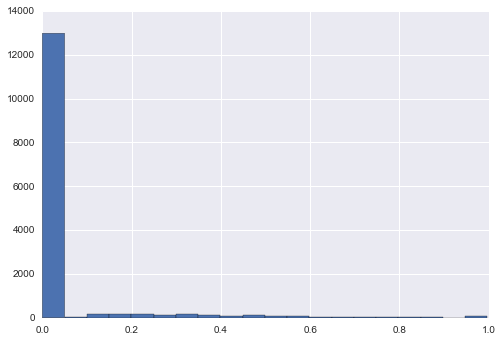

In [552]:
ax =kagSortedDf2['col1'].hist(bins=20)
plt.show()


In [127]:
#cleanKagTweetList
list(kagSortedDf[kagSortedDf.col1>0.1].index)
#kagTweets.loc[list(set(kagSortedDf[kagSortedDf.col1>0.1].index))]['text']

[55,
 66,
 67,
 70,
 86,
 89,
 98,
 101,
 107,
 114,
 126,
 137,
 156,
 158,
 159,
 196,
 200,
 201,
 205,
 226,
 232,
 235,
 277,
 282,
 318,
 326,
 334,
 335,
 340,
 344,
 360,
 365,
 372,
 386,
 445,
 450,
 456,
 463,
 479,
 487,
 499,
 509,
 564,
 569,
 573,
 593,
 606,
 610,
 643,
 650,
 652,
 655,
 675,
 700,
 704,
 711,
 715,
 716,
 719,
 764,
 786,
 792,
 796,
 803,
 808,
 833,
 843,
 844,
 847,
 862,
 884,
 899,
 918,
 923,
 928,
 934,
 939,
 960,
 961,
 986,
 990,
 996,
 1008,
 1041,
 1064,
 1070,
 1073,
 1097,
 1098,
 1102,
 1119,
 1121,
 1130,
 1133,
 1135,
 1149,
 1158,
 1166,
 1215,
 1229,
 1263,
 1265,
 1266,
 1269,
 1272,
 1287,
 1294,
 1297,
 1326,
 1331,
 1333,
 1346,
 1350,
 1361,
 1373,
 1419,
 1422,
 1436,
 1468,
 1510,
 1520,
 1527,
 1533,
 1561,
 1570,
 1590,
 1600,
 1621,
 1656,
 1660,
 1673,
 1688,
 1718,
 1719,
 1732,
 1747,
 1760,
 1761,
 1766,
 1767,
 1773,
 1781,
 1796,
 1800,
 1813,
 1816,
 1824,
 1839,
 1847,
 1874,
 1875,
 1879,
 1896,
 1901,
 1904,
 191

In [ ]:
list(kagSortedDf[kagSortedDf.col1>0.1].index)

In [128]:
#kagSortedDf[(kagSortedDf.col1>0.4) & (kagSortedDf.col1<0.5)]

In [129]:
kagTweets.loc[89]['text']

'@VirginAmerica Why is the site down?  When will it be back up?'

In [84]:
kagCleanArray = np.array(cleanKagTweetList)
#kagCleanArray
srtIdx = list(kagSortedDf[kagSortedDf.col1>0.1].index)
srtTweets = list(kagCleanArray[srtIdx])
topicCloudWords = ' '.join([' '.join(string) for string in srtTweets])

In [107]:
#srtTweets

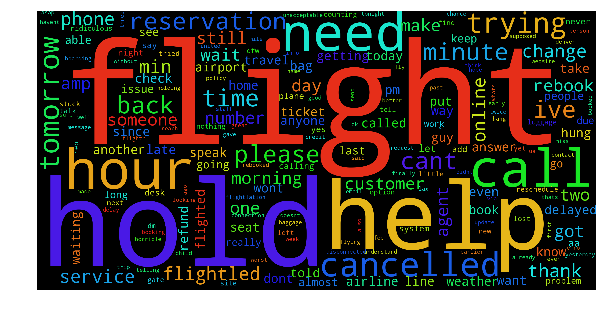

In [206]:
#topicCloud = WordCloud(max_font_size=100,scale=8).generate(topicCloudWords)
#topicCloud = WordCloud(max_font_size=100,scale=8).generate(' '.join([' '.join(string) for string in srtTweets]))

myTopicCloud = makeWordCloud(cleanKagTweetList)

fig = plt.figure(figsize=(10,10), dpi=1600)
plt.imshow(myTopicCloud)
plt.axis("off")
plt.show()

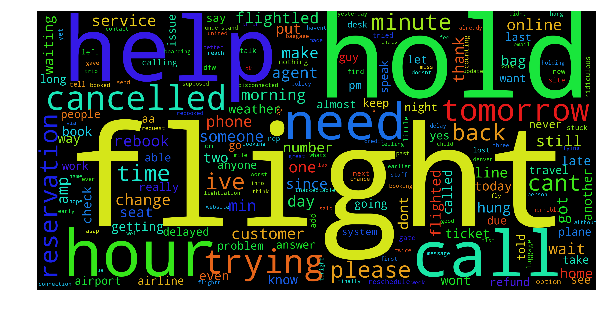

In [203]:
topicCloud = WordCloud(max_font_size=100,scale=8).generate(topicCloudWords)
#topicCloud = WordCloud(max_font_size=100,scale=8).generate(' '.join([' '.join(string) for string in srtTweets]))

fig = plt.figure(figsize=(10,10), dpi=1600)
plt.imshow(topicCloud)
plt.axis("off")
plt.show()

### Parameters I want to get an intuition for
1. What are perplexity metrics?
2. How many documents do I need for this to be effective?
3. How does using a different alpha value change the topics obtained by the model?
4. Does topic number reduce perplexity? Will more topics always reduce perplexity?


In [93]:
#models.ldamulticore.LdaMulticore.log_perplexity(kagLda)
kagLda.log_perplexity(kagCorpus)

-9.3352311417525442

In [110]:
tempLDA = createLDA(kagCorpus, kagDict,myTopics=20)

In [111]:
pyLDAvis.gensim.prepare(tempLDA, kagCorpus, kagDict)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      12.342593        1       1 -0.167412 -0.023112
16      7.595106        1       2 -0.102757 -0.081826
9       6.556064        1       3 -0.053864  0.026497
0       5.960392        1       4 -0.076083 -0.113312
8       5.541048        1       5 -0.049382  0.062970
14      5.492479        1       6 -0.024098  0.070083
1       5.228620        1       7  0.136721 -0.142235
4       5.126752        1       8  0.059396 -0.070064
2       4.507879        1       9 -0.031332 -0.003253
6       4.335051        1      10  0.193753 -0.106785
17      4.271573        1      11 -0.058222 -0.060857
11      4.223480        1      12  0.002392  0.030150
3       4.061831        1      13  0.052400  0.025468
5       3.983982        1      14  0.004033  0.021925
18      3.929081        1      15 -0.068613 -0.028847
19      3.906088        1      16 -0.083709  0.042434
10      3.783042        1      17  0.055068 -0.005059
15      3.509125        1      18  0.032857  0.130090
12      3.312629        1      19  0.113096  0.152488
13      2.333186        1      20  0.065756  0.073245, topic_info=      Category         Freq             Term  Total  loglift  logprob
7674   Default  1048.000000        cancelled   1048  30.0000  30.0000
322    Default   976.000000          service    976  29.0000  29.0000
6725   Default   755.000000              bag    755  28.0000  28.0000
2550   Default   917.000000         customer    917  27.0000  27.0000
7318   Default   601.000000            thank    601  26.0000  26.0000
11646  Default  4494.000000           flight   4494  25.0000  25.0000
1277   Default   502.000000        flightled    502  24.0000  24.0000
3775   Default  1066.000000           thanks   1066  23.0000  23.0000
6426   Default   548.000000             call    548  22.0000  22.0000
8375   Default   555.000000           please    555  21.0000  21.0000
1761   Default   714.000000            plane    714  20.0000  20.0000
10450  Default   216.000000          jetblue    216  19.0000  19.0000
11148  Default   232.000000            worst    232  18.0000  18.0000
139    Default   637.000000             hold    637  17.0000  17.0000
7822   Default   538.000000          airline    538  16.0000  16.0000
6375   Default   243.000000             ever    243  15.0000  15.0000
8870   Default   253.000000               dm    253  14.0000  14.0000
7539   Default  1371.000000              get   1371  13.0000  13.0000
5290   Default   152.000000            fleet    152  12.0000  12.0000
5281   Default   148.000000            fleek    148  11.0000  11.0000
2881   Default   246.000000            email    246  10.0000  10.0000
6385   Default   317.000000            never    317   9.0000   9.0000
8139   Default   423.000000             late    423   8.0000   8.0000
9654   Default   539.000000             gate    539   7.0000   7.0000
4264   Default   305.000000         tomorrow    305   6.0000   6.0000
3163   Default   308.000000          problem    308   5.0000   5.0000
11119  Default   127.000000           follow    127   4.0000   4.0000
4278   Default   223.000000         flighted    223   3.0000   3.0000
4676   Default   519.000000          delayed    519   2.0000   2.0000
6994   Default   306.000000           flying    306   1.0000   1.0000
...        ...          ...              ...    ...      ...      ...
7258   Topic20    36.588606            agent    413   1.4043  -4.3263
7372   Topic20     4.984469           living      9   3.3482  -6.2086
8323   Topic20    14.631926             fine     39   2.5949  -5.4956
8593   Topic20    22.594550           newark     57   2.3905  -5.3205
6457   Topic20     1.997503  #thenewamerican      4   3.7437  -6.6241
8209   Topic20     9.258771         pleasant     14   3.0659  -6.0492
5179   Topic20    22.141076          flightr    155   1.7151  -4.9956
6540   Topic20     3.257620     indiana

### Could be nice to see which airline has the most trouble or gets the most positive responses

In [99]:
#get unique airlines in dataset
np.unique(kagTweets['airline'])

array(['American', 'Delta', 'Southwest', 'US Airways', 'United',
       'Virgin America'], dtype=object)

In [101]:
tempLDA = createLDA(kagCorpus, kagDict,myPasses=1,myIterations=1)

In [103]:
tempLDA.log_perplexity(kagCorpus)

-35.165851361464973

In [105]:
myNumTopics = [5,10,15,20,30,40,50,60,70,80,90,100,125,150,175,200]

In [106]:
for i in myNumTopics:
    tempLDA = createLDA(kagCorpus, kagDict,myPasses=10,myIterations=50,myTopics=i)
    print tempLDA.log_perplexity(kagCorpus)

-8.59480084875
-8.78183116319
-8.88128765747
-8.98503369168
-9.1106256775
-9.25185504989
-9.33457901644
-9.4047096351
-9.45487341335
-9.52136222915
-9.58958047556
-9.5906977889
-9.72553756621
-9.80253888669
-9.84237057044
-9.83243885693


In [ ]:
kagLda = createLDA(kagCorpus, kagDict)

In [104]:
kagLda.num_topics

50

In [ ]:
>>> import numpy as np
>>> a = np.array([-2, 1, 5, 3, 8, 5, 6])
>>> b = [1, 2, 5]
>>> print list(a[b])
[1, 5, 5]

In [ ]:
#kagDf.iloc[translateIdx].reset_index()

In [ ]:
#np.sort(kagDf.loc[39,])
kagDf.sort_values()

# Try to implement bigrams into analysis

In [ ]:
from gensim.models.phrases import Phrases
from gensim import similarities


In [ ]:
def getBigram(myTweetlist):
    bigram = Phrases(tweetList)
    return [bigram[tweet] for tweet in myTweetlist]

In [ ]:
cleanTweets = filterTweetList(tweets['message'])
bigramTweetList = getBigram(cleanTweets)

In [ ]:
bigramDict = makeDict(bigramTweetList)
bigramCorpus = makeCorpus(bigramTweetList)

#bigramDict = bigramDict.compactify()
bigramLda = createLDA(myCorpus = bigramCorpus, myDictionary = bigramDict)
#dictionary.

#createLDA()

In [ ]:
bigramDict = makeDict(bigramTweetList)
bigramLda = createLDA(myCorpus = bigramCorpus, myDictionary = bigramDict)

In [ ]:
#bigramDict = bigramDict.compactify()

In [ ]:
pyLDAvis.gensim.prepare(bigramLda, bigramCorpus, bigramDict)

# Code for single tweet validation 

In [ ]:
# First, build index in order to query the model

myIndex = MatrixSimilarity(lda[myCorpus]) # transform corpus to LSI space and index it
sims = myIndex[myVec_lda] # perform a similarity query against the corpus
sims = sorted(enumerate(sims), key=lambda item: -item[1])



In [ ]:
# Function for tweet validation

def validateTweet(testTweet, myDict=myDict, myLda=lda ):
    myDoc = ' '.join([prepText(word) for word in testTweet.split() if prepText(word) is not None])    
    myVec_bow = myDict.doc2bow(myDoc.lower().split())
    myVec_lda = myLda[myVec_bow]
    sims = myIndex[myVec_lda] # perform a similarity query against the corpus
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    matchIdx = [i[0] for i in sims[1:300]]
    topHandlers = list(tweets.iloc[matchIdx]['fromHandler'])
    return topHandlers

validateTweet("@JennyMcCarthy #dsf I wrote a children's book about bullying. It's on Amazon. Want to help promote it?!? The Bully's Nightmare")

In [ ]:
#Trial tweet for validation

myDoc = '@saracozart No need to continue the struggle. Were here and we can help. DM us for info about switching. http://spr.ly/6017BkrjL* OMV'
myDocOrig = "@ATT @ATTCares I have been on hold for one hour & 11minutes. This is a little excessive. Worst customer service I've ever received."
myDoc = ' '.join([prepText(word) for word in myDoc.split() if prepText(word) is not None])
print myDoc                
myVec_bow = myDict.doc2bow(myDoc.lower().split())
#myVec_bow = dictionary.doc2bow(myDoc.lower().split())
myVec_lda = lda[myVec_bow]
print(myVec_lda)

In [ ]:
# Find the best 300 tweet matches
matchIdx = [i[0] for i in sims[1:300]]
topHandlers = list(tweets.iloc[matchIdx]['fromHandler'])

In [ ]:
#>>> sims = myIndex[myVec_lda] # perform a similarity query against the corpus
#>>> print(list(enumerate(sims))) # print (document_number, document_similarity) 2-tuples

In [ ]:
#>>> sims = sorted(enumerate(sims), key=lambda item: -item[1])
#>>> print(sims) # print sorted (document number, similarity score) 2-tuples

In [ ]:
# Find the best 300 tweet matches
#matchIdx = [i[0] for i in sims[1:300]]


In [ ]:
topHandlerCounts = Counter(topHandlers)
sortedHandlers = sorted(topHandlerCounts.items(), key=lambda x: x[1],reverse=True)[0:5]

handlerNames = [handler[0] for handler in sortedHandlers]
handlerCounts = [handler[1] for handler in sortedHandlers]

indexes = np.arange(len(handlerNames))
width = 0.9
plt.bar(indexes, handlerCounts, width)
plt.xticks(indexes + width * 0.5, handlerNames)
plt.ylabel('Frequency',fontsize=16)

# Plot histogram using matplotlib bar().
#indexes = np.arange(len(author_names))
#width = 0.7
#plt.bar(indexes, author_counts, width)
#plt.xticks(indexes + width * 0.5, author_names)
plt.show()
#

In [ ]:
#Trial tweet for validation LSI

myDoc = '@saracozart No need to continue the struggle. Were here and we can help. DM us for info about switching. http://spr.ly/6017BkrjL* OMV'
myDocOrig = "@ATT @ATTCares I have been on hold for one hour & 11minutes. This is a little excessive. Worst customer service I've ever received."
myDoc = ' '.join([prepText(word) for word in myDoc.split() if prepText(word) is not None])
print myDoc                
myVec_bow = myDict.doc2bow(myDoc.lower().split())
#myVec_bow = dictionary.doc2bow(myDoc.lower().split())
myVec_lsi = lsi[myVec_bow]
print(myVec_lsi)

In [ ]:
# How would I get the topic distribution for the top tweets?

In [ ]:
simsLsi = myIndex[myVec_lsi] # perform a similarity query against the corpus
simsLsi = sorted(enumerate(simsLsi), key=lambda item: -item[1])
matchIdx = [i[0] for i in simsLsi[1:300]]
topHandlers = list(tweets.iloc[matchIdx]['fromHandler'])

In [ ]:
topHandlers

In [ ]:
#83287 words
# 50 topics
myIndex.index.shape

In [ ]:
# All 80k tweets for 4th topic
myIndex.index[:,4]

In [ ]:
# All 50 topics for 4th tweet
myIndex.index[4,:]

In [ ]:
#lda.print_topic(49)
lda.show_topic(49)

In [ ]:
tweets.iloc[matchIdx][1:300]

In [ ]:
sims[1:300]

In [ ]:
myDoc = '@saracozart No need to continue the struggle. Were here and we can help. DM us for info about switching. http://spr.ly/6017BkrjL* OMV'

>>> doc = "Human computer interaction"
>>> vec_bow = dictionary.doc2bow(doc.lower().split())
>>> vec_lsi = lsi[vec_bow] # convert the query to LSI space
>>> print(vec_lsi)

In [ ]:
>>> index = similarities.MatrixSimilarity(lsi[corpus]) # transform corpus to LSI space and index it

In [ ]:
>>> sims = index[vec_lsi] # perform a similarity query against the corpus
>>> print(list(enumerate(sims))) # print (document_number, document_similarity) 2-tuples

In [ ]:
>>> sims = sorted(enumerate(sims), key=lambda item: -item[1])
>>> print(sims) # print sorted (document number, similarity score) 2-tuples

In [ ]:
tweets.iloc[35536]['message']

In [ ]:
bigram = Phrases(tweetList)

In [ ]:
#from gensim.models import Phrases


#print bigram[tweetList[152:153]]

test     = bigram[tweetList[152:153]]
#testDict = Phrases(tweetList[152:153])

testDict =  corpora.Dictionary(test)
#print bigram[tweetList[152:153]]
print test.corpus
#phraseTest = Phrases(tweetList[152:153])


In [ ]:
for i in range(152,200):
    print bigram[tweetList[i]]

In [ ]:
#lda

In [ ]:
tfidf_lda= models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=8, passes = 10,
    iterations=50)

In [ ]:
topTopicsTfIdf = tfidf_lda.top_topics(corpus_tfidf)

In [ ]:
#topTopicsTfIdf
#pyLDAvis.gensim.prepare(tfidf_lda, corpus_tfidf, dictionary)

In [ ]:
frq = nltk.FreqDist(tweetList[3])

In [ ]:
polstops = [w[0] for w in frq.most_common(int(0.3*len(frq)))]
polstops

In [ ]:
frq.most_common(int(0.3*len(frq)))

In [ ]:
[w[0] for w in frq.most_common(int(0.1*len(frq)))]

In [ ]:
[word for word in tweetList[3] if word not in polstops]

In [ ]:
secTweetList = [[word for word in s if word not in polstops] for s in speeches]    

In [ ]:
for i in tweets['message']:
    if 'xi ' in i:
        print i

#'Just' in tweets['message'].iloc[0]

In [ ]:
iter

In [ ]:
tweets

# Try to get count vectorizer for bag of words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
vectorizer = CountVectorizer(min_df=1)


In [ ]:
X = vectorizer.fit_transform(verTweets['message'])

In [ ]:
#list(verTweets['message'])

# Trying gensim

In [ ]:
from gensim import corpora, models, similarities
from gensim.models import ldamodel

In [ ]:
list(verTweets['message'])

In [ ]:
>>> # remove common words and tokenize
documents = list(verTweets['message'])

>>> stoplist = set('for a of the and to in'.split())
>>> texts = [[word for word in document.lower().split() if word not in stoplist]
>>>          for document in documents]
>>>
>>> # remove words that appear only once
>>> from collections import defaultdict
>>> frequency = defaultdict(int)
>>> for text in texts:
>>>     for token in text:
>>>         frequency[token] += 1
>>>
>>> texts = [[token for token in text if frequency[token] > 1]
>>>          for text in texts]
>>>
>>> from pprint import pprint   # pretty-printer
#>>> pprint(texts)

In [ ]:
>>> dictionary = corpora.Dictionary(texts)
>>> dictionary.save('/tmp/deerwester.dict') # store the dictionary, for future reference
>>> print(dictionary)

In [ ]:
#lda = ldamodel.LdaModel(list(verTweets['message']), num_topics=10)

In [ ]:
ldamodel.

In [ ]:
print 'Representative duplicate tweet: \n'
print tweets.iloc[45185]['message']


In [ ]:
# Count the number of occurences of the above tweet

print tweets.iloc[45194]['message']
print
msg1 = 'I always confuse @JetBlue crew members when I use this bag\xe2\x80\xa6 \xe2\x80\x9cNo I don\xe2\x80\x99t work for JB\xe2\x80\xa6 ish\xe2\x80\xa6\xe2\x80\x9d\nWheels up to Boston! https://t.co/61fKRnYNpK'
dups1 = tweets[tweets.message == msg1]
print "number of dups: " + str(len(dups1)) + '\n'
dups1.head()


In [ ]:
def dupCounter(msg):
    """Count the number of repeated tweets that match a given string"""
    dups = tweets[tweets.message == msg]
    dups.head()
    return len(dups)

dupCounter(tweets.iloc[45194]['message'])    

In [ ]:
# Get all unique tweets

uniqTweets = list(set(tweets['message']))

print 'number of unique tweets: ' + str(len(uniqTweets))

# Only 136 unique tweets. Something looks wrong.

In [ ]:
# For each unique tweet, count the number of duplicate tweets 
dupCounts = []

for i in uniqTweets:
    dupCounts.append(dupCounter(i))


In [ ]:
#Plot the redundancy of tweets

plt.bar([i for i in range(len(dupCounts))],dupCounts)
plt.ylabel('Tweet redundancy',fontsize=16)
#plt.title('duplicate tweets',fontsize=24)
#plt.xlabel('unique tweets')
#plt.bar([i for i in range(10)],range(10))

plt.ylim([0,7000])

plt.show()

# Preliminary tweet cleaning

In [ ]:
# To build a list of tweets coming from and to JetBlue

toJetTweets   = list(set(tweets.loc[tweets.toHandler == '@JetBlue','message']))
fromJetTweets = list(set(tweets.loc[tweets.toHandler != '@JetBlue','message']))

In [ ]:
#[i.lower() for i in ' '.join(toJetTweets).split()]

In [ ]:
wordList = [i.lower() for i in ' '.join(uniqTweets).split()]
wordList = [i for i in wordList if i not in stopwords.words('english')]
#filtWords = [i for i in skillList.split() if i not in stopwords.words('english')]

In [ ]:
#wordList

In [ ]:
freqWord = Counter(wordList).most_common(10)

In [ ]:
def getFreqWords(tweetList,topWordThresh=10):
    wordList = [i.lower() for i in ' '.join(tweetList).split()]
    wordList = [i for i in wordList if i not in stopwords.words('english')]
    return Counter(wordList).most_common(topWordThresh)
getFreqWords(uniqTweets)

In [ ]:
uniqTweets
toJetTweets

In [ ]:
def plotFreqWords(freqWords):
    fig = plt.figure(figsize=(5,4), dpi=1600)
    ax = fig.add_subplot(111)

    plt.bar([i for i in range(10)],[i[1] for i in freqWords],alpha=0.7)
    plt.xticks([i+0.5  for i in range(10)], [i[0] for i in freqWords], rotation='vertical')

    ax.set_xticklabels([i[0] for i in freqWords],rotation=45,ha='right')
    ax.set_ylim(0,25)
    ax.set_ylabel('Word Frequency',fontsize=16)

    plt.show()
    
plotFreqWords(getFreqWords(fromJetTweets))

In [ ]:
fig = plt.figure(figsize=(5,4), dpi=1600)
ax = fig.add_subplot(111)


plt.bar([i for i in range(10)],[i[1] for i in freqWord],alpha=0.7)
plt.xticks([i+0.5  for i in range(10)], [i[0] for i in freqWord], rotation='vertical')

ax.set_xticklabels([i[0] for i in freqWord],rotation=45,ha='right')
ax.set_ylim(0,25)
ax.set_ylabel('Word Frequency',fontsize=16)

plt.show()

In [ ]:
for i in uniqTweets:
    if 'thanks' in i:
        print i
    

In [ ]:
x = [1, 2, 3, 4]
y = [1, 4, 9, 6]
labels = ['Frogs', 'Hogs', 'Bogs', 'Slogs']

plt.plot(x, y, 'ro')
# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(x, labels, rotation='vertical')
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()

In [ ]:
[len(freqWord)]

In [ ]:
sorted(wordList.items(), key=operator.itemgetter(1),reverse=True)

In [ ]:
sortedFreq = sorted(wordList.items(), key=operator.itemgetter(1),reverse=True)

In [ ]:
dict(sortedFreq)

In [ ]:
#plt.plot([i for i in range(len(sortedFreq))],sortedFreq)

In [ ]:
print tweets.iloc[45185]['message']

In [ ]:
print tweets.iloc[45229]['message']
tweets.iloc[45229]['message']

In [ ]:
tknzr = TweetTokenizer()

In [ ]:
tknzr.tokenize(tweets.iloc[45229]['message'])

In [ ]:
len(list(set(tweets.message)))

In [ ]:
[i for i in wordList if i.startswith('#')]
[i for i in wordList if i.startswith('@')]

In [ ]:
print uniqTweets[0]
tknzr.tokenize(uniqTweets[0])

# Some sklearn stuff

In [ ]:
from sklearn.feature_extraction import DictVectorizer

In [ ]:
measurements = [
...     {'city': 'Dubai', 'temperature': 33.},
...     {'city': 'London', 'temperature': 12.},
...     {'city': 'San Fransisco', 'temperature': 18.},
... ]

In [ ]:
vec = DictVectorizer()

In [ ]:
vec.fit_transform(measurements).toarray()

In [ ]:
vec.get_feature_names()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer(min_df=1)
vectorizer             

In [ ]:
>>> corpus = [
...     'This is the first document.',
...     'This is the second second document.',
...     'And the third one.',
...     'Is this the first document?',
... ]
>>> X = vectorizer.fit_transform(corpus)
>>> X             

In [ ]:
>>> analyze = vectorizer.build_analyzer()
>>> analyze("This is a text document to analyze.") == (
...     ['this', 'is', 'text', 'document', 'to', 'analyze'])


In [ ]:
>>> vectorizer.get_feature_names() == (
...     ['and', 'document', 'first', 'is', 'one',
...      'second', 'the', 'third', 'this'])
True

>>> X.toarray()           

In [ ]:
>>> vectorizer.vocabulary_.get('document')

In [ ]:
>>> vectorizer.transform(['Something completely new.']).toarray()

In [ ]:
>>> bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
...                                     token_pattern=r'\b\w+\b', min_df=1)
>>> analyze = bigram_vectorizer.build_analyzer()
>>> analyze('Bi-grams are cool!') == (
...     ['bi', 'grams', 'are', 'cool', 'bi grams', 'grams are', 'are cool'])

In [ ]:
>>> X_2 = bigram_vectorizer.fit_transform(corpus).toarray()
>>> X_2

In [ ]:
>>> feature_index = bigram_vectorizer.vocabulary_.get('is this')
>>> X_2[:, feature_index]     

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np


In [ ]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
#categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

In [ ]:
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

In [ ]:
print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

In [ ]:
dataset.keys()
#dataset['DESCR']

In [ ]:
use_hashing = True
use_idf = True
n_features = 10000

print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
if use_hashing:
    if use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=n_features,
                                   stop_words='english', non_negative=True,
                                   norm=None, binary=False)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=n_features,
                                       stop_words='english',
                                       non_negative=False, norm='l2',
                                       binary=False)
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=use_idf)
X = vectorizer.fit_transform(dataset.data)


In [ ]:
n_components = 0
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()


In [ ]:
###############################################################################
# Do the actual clustering

minibatchBool = True
verboseBool = False

if minibatchBool:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=verboseBool)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()

In [ ]:
use_hashing = False

if not use_hashing:
    print("Top terms per cluster:")

    if n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

In [ ]:
dbname = 'tweets'
username = 'Peter'

In [ ]:
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print engine.url

In [ ]:
# Needed to use `createdb Peter` on bash terminal before psql would work
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

In [ ]:
tweets.to_sql('tweets_table', engine, if_exists='replace')

In [ ]:
# Create connection to database
con = psycopg2.connect(database = dbname, user = username)

In [ ]:
# query:
#sql_query = """
#SELECT * FROM tweets_table;
#"""

#select id, account, message from tweets_table limit 20;
#select * from tweets_table limit 20; 

sql_query = """
select id, account, message, tweet_id from tweets_table limit 5;
"""

def sqlPandasQuery(myQuery):
    tweets_from_sql = pd.read_sql_query(myQuery,con)
    return tweets_from_sql

sqlPandasQuery(sql_query)

In [ ]:
### can I do a SQL query to find conversations of given length?


In [ ]:
tweets.to_sql('tweets_table', engine, if_exists='replace')

In [ ]:
# Create connection to database
con = psycopg2.connect(database = dbname, user = username)

In [ ]:
# query:
#sql_query = """
#SELECT * FROM tweets_table;
#"""

#select id, account, message from tweets_table limit 20;
#select * from tweets_table limit 20; 

sql_query = """
select id, account, message, tweet_id from tweets_table limit 5;
"""

def sqlPandasQuery(myQuery):
    tweets_from_sql = pd.read_sql_query(myQuery,con)
    return tweets_from_sql

sqlPandasQuery(sql_query)

In [ ]:
### can I do a SQL query to find conversations of given length?

In [16]:
%%timeit
# Using iterator:             10 loops, best of 3: 137 ms per loop
# Using double list comprhxn: 10 loops, best of 3: 141 ms per loop

# Iterator
for tweet in (tweet for tweet in verTweets['message']):
    [word.lower() for word in tweet.split() if word not in str(stopwords.words('english')) and not word.startswith('@') and not word.startswith('http')]
#[[word.lower() for word in tweet.split() if word not in stopwords.words('english') and not word.startswith('@') and not word.startswith('http')] for tweet in verTweets['message']]


1 loops, best of 3: 7.9 s per loop


### Using an iterator doesn't speed up the data cleaning

## Wanted to check the speed saved by parallelization using `%%timeit`
#### Without multicore:  
_Code_  
`lda = models.LdaMulticore(corpus, id2word=dictionary, num_topics=50, passes=10, iterations=50,alpha=0.001)`  

_`Output from %%timeit`_  
`1 loops, best of 3: 11min 10s per loop`

#### With multicore:  
_Code_  
`lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=50, passes = 10,iterations=50,alpha=0.001)`  
_`Output from %%timeit`_  
`1 loops, best of 3: 6min 17s per loop`  



# Bottom line: _multicore LDA is about twice as fast_
